# Cophylogeny plots
Investigate congruence betwen nextstrain trees and sc2ts trees. Produced "untangled" simplified tree sequences for plotting tanglegrams

In [1]:
import sys
import datetime
import shutil
import gzip
import tempfile
import os
import re
import subprocess

import numpy as np
import tskit
import tszip
import sc2ts

# Look for most stuff in the root dir - assumes we are running within `notebooks`
sys.path.append("..")

import utils

# NB - you will need to replace this with the appropriate local location
dendroscope_binary = (
    "/Applications/Dendroscope/Dendroscope.app/Contents/MacOS/JavaApplicationStub"
)

In [2]:
ts_dir = "../data"
long_filename = os.path.join(ts_dir, "upgma-mds-1000-md-30-mm-3-2022-06-30-recinfo2-gisaid-il")
wide_filename = os.path.join(ts_dir, "upgma-full-md-30-mm-3-2021-06-30-recinfo2-gisaid-il")
ts_long = tszip.decompress(long_filename + ".ts.tsz")
ts_wide = tszip.decompress(wide_filename + ".ts.tsz")
pos = int(ts_wide.sequence_length / 2)

In [3]:
def run_nnet_untangle(trees):
    assert len(trees) == 2
    with tempfile.TemporaryDirectory() as tmpdirname:
        newick_path = os.path.join(tmpdirname, "cophylo.nwk")
        command_path = os.path.join(tmpdirname, "commands.txt")
        with open(newick_path, "wt") as file:
            for tree in trees:
                print(tree.as_newick(), file=file)
        with open(command_path, "wt") as file:
            print(f"open file='{newick_path}';", file=file)
            print("compute tanglegram method=nnet", file=file)
            print(
                f"save format=newick file='{newick_path}'", file=file
            )  # overwrite
            print("quit;", file=file)
        subprocess.run([dendroscope_binary, "-g", "-c", command_path])
        order = []
        with open(newick_path, "rt") as newicks:
            for line in newicks:
                # hack: use the order of `nX encoded in the string
                order.append([int(n[1:]) for n in re.findall(r"n\d+", line)])
    return order

def get_simplified(ts, nx_ts, pos, filter_nodes=True, delete_other_trees=True, untangle=False):
    # Slow step: find the samples in ts also in nx_ts, and subset
    sc2ts_its, nxstr_its = sc2ts.subset_to_intersection(
        ts, nx_ts, filter_sites=False, keep_unary=True, filter_nodes=filter_nodes
    )

    print(
        f"Num samples in subsetted ARG={sc2ts_its.num_samples} vs "
        f"NextStrain={nxstr_its.num_samples}"
    )
    # Check first set of samples map
    if filter_nodes:
        for u, v in zip(sc2ts_its.samples(), nxstr_its.samples()):
            assert sc2ts_its.node(u).metadata["strain"] == nxstr_its.node(v).metadata["strain"]

    ## Filter from entire TS:
    # Some of the samples in sc2_its are recombinants: remove these from both trees
    sc2ts_simp_its = sc2ts_its.simplify(
        sc2ts_its.samples()[0 : nxstr_its.num_samples],
        keep_unary=True,
        filter_nodes=filter_nodes,
    )
    assert sc2ts_simp_its.num_samples == sc2ts_simp_its.num_samples
    if filter_nodes:
        for u, v in zip(sc2ts_simp_its.samples(), nxstr_its.samples()):
            assert (
                sc2ts_simp_its.node(u).metadata["strain"]
                == nxstr_its.node(v).metadata["strain"]
            )
    print(
        f"Removed {sc2ts_its.num_samples-sc2ts_simp_its.num_samples} samples "
        "in sc2 not in nextstrain"
    )

    ## Filter from trees
    # Some samples in sc2ts_simp_its are internal. Remove those from both datasets
    keep = np.array([u for u in sc2ts_simp_its.at(pos).leaves()])
    sc2ts_tip = sc2ts_simp_its.simplify(keep, keep_unary=True, filter_nodes=filter_nodes)


    print(
        f"Removed samples that are internal in tree at pos {pos}. "
        f"Trees now have {sc2ts_tip.num_samples} leaf samples and "
        f"{(sc2ts_tip.nodes_flags & sc2ts.NODE_IS_RECOMBINANT > 0).sum()} recmb nodes"
    )

    if not untangle:
        return sc2ts_tip, nxstr_its

    assert nxstr_its.num_trees == 1
    nxstr_tip = nxstr_its.simplify(keep)

    # Change the random seed here to change the untangling start point
    # rng = np.random.default_rng(777)
    # keep = rng.shuffle(keep)

    sc2ts_tip = sc2ts_tip.simplify()  # remove unary nodes (e.g. recmb nodes)
    # Call the java untangling program
    sc2ts_order, nxstr_order = run_nnet_untangle(
        [sc2ts_tip.at(pos), nxstr_tip.first()]
    )
    nxstr_order = list(
        reversed(nxstr_order)
    )  # RH tree rotated so reverse the order
    plotted_sc2ts_ts = sc2ts_tip.simplify(sc2ts_order)
    plotted_nxstr_ts = nxstr_tip.simplify(nxstr_order)
    if delete_other_trees:
        return (
            plotted_sc2ts_ts.keep_intervals([sc2ts_tip.at(pos).interval]),
            plotted_nxstr_ts.keep_intervals([nxstr_tip.at(pos).interval]),
        )
    else:
        return plotted_sc2ts_ts, plotted_nxstr_ts

In [4]:
nx_fn = "nextstrain_ncov_gisaid_global_all-time_timetree-2023-01-21.nex"
assert ts_long.sequence_length == ts_wide.sequence_length
with tempfile.TemporaryDirectory() as tmpdir:
    with gzip.open(os.path.join(ts_dir, nx_fn + ".gz")) as f_in:
        new_fn = os.path.join(tmpdir, nx_fn)
        with open(new_fn, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)
        nextstrain_ts_tmp = sc2ts.newick_from_nextstrain_with_comments(
            sc2ts.extract_newick_from_nextstrain_nexus(new_fn),
            min_edge_length=0.0001 * 1/365,
            span=ts_long.sequence_length,
        )
        # Remove "samples" without names
        keep = [n.id for n in nextstrain_ts_tmp.nodes() if n.is_sample() and "strain" in n.metadata]
        nextstrain_ts = nextstrain_ts_tmp.simplify(keep)

## Investigate reasons for breakpoints in the supposedly non-recombinant Nextclade subset

(Using the same subset of samples as in the tanglegrams)

NB: For the various rounds of simplification we use filter_nodes=False so that
we keep the same node IDs

### Plot a subset

In [5]:
ts, nx_ts = get_simplified(ts_wide, nextstrain_ts, pos=pos, filter_nodes=False, delete_other_trees=False)

Num samples in subsetted ARG=187 vs NextStrain=180
Removed 7 samples in sc2 not in nextstrain
Removed samples that are internal in tree at pos 14952. Trees now have 173 leaf samples and 4123 recmb nodes


In [6]:
tree = ts.first()
untouched_by_recomb = []
for sample in ts.samples():
    u = sample
    affected_by_recomb = False
    while u != -1:
        e = ts.edge(tree.edge(u))
        if e.left != 0 or e.right != ts.sequence_length:
            affected_by_recomb = True
            break
        u = tree.parent(u)
    if not affected_by_recomb:
        untouched_by_recomb.append(sample)

In [7]:
keep = [s for s in ts.samples() if s not in set(untouched_by_recomb)]
simp = ts.simplify(keep, keep_unary=True, filter_nodes=False)
print(simp.num_trees, "trees in the simplified ARG")
print(simp.num_samples, "samples touched by a recombination in the simplified ARG")

8 trees in the simplified ARG
16 samples touched by a recombination in the simplified ARG


## Plot the trees out

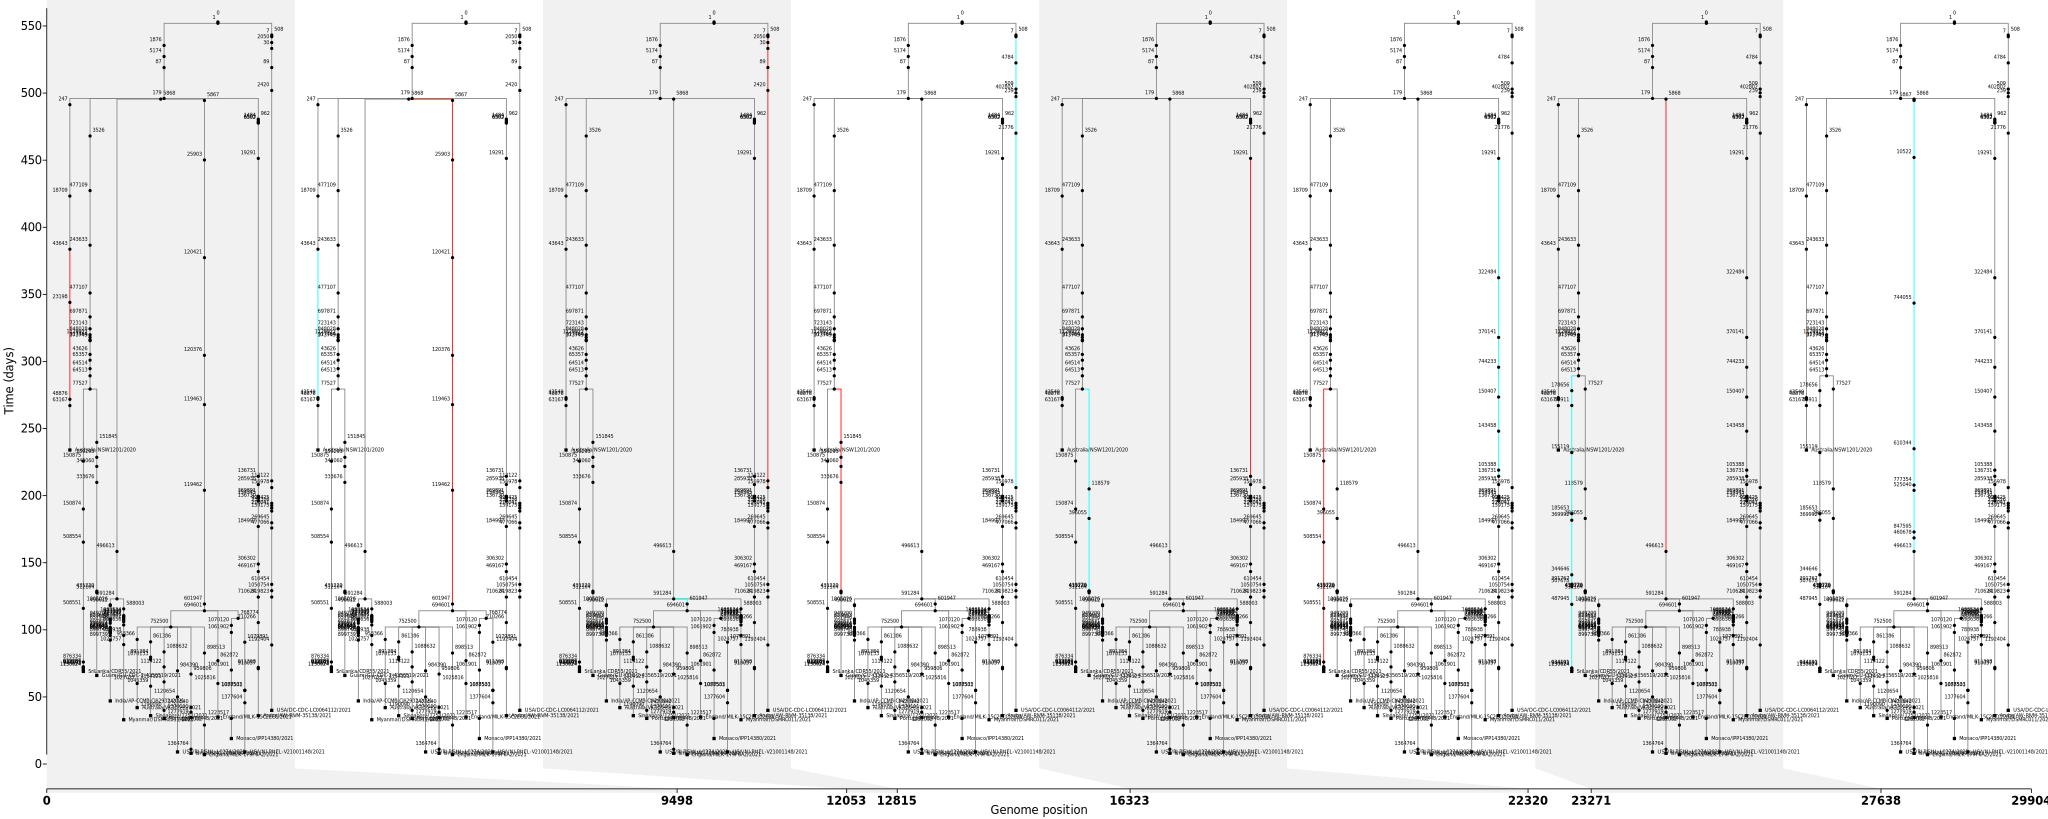

In [8]:
import collections

style = ".node .lab {font-size:6px} .leaf .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}"
style += ".edge {stroke: grey}"
e_out = collections.defaultdict(set)
e_in = collections.defaultdict(set)
for tree_id, ed in enumerate(simp.edge_diffs()):
    if ed.interval.left != 0:
        for i in ed.edges_in:
            e_in[tree_id].add((i.parent, i.child))
    for o in ed.edges_out:
        e_out[tree_id - 1].add((o.parent, o.child))
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: red}}"
    for tree, edges in e_out.items()
    for c in edges])
style += ''.join([
    f".t{tree} .a{c[0]}.n{c[1]} > .edge {{stroke: cyan}}"
    for tree, edges in e_in.items()
    for c in edges])

shown_nodes = {u for tree in simp.trees() for u in tree.nodes()}
node_labels = {u: (simp.node(u).metadata.get("strain", "") if simp.node(u).is_sample() else u) for u in shown_nodes}
simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels=node_labels
)

We can collapse some nodes here: 694601 is the obvious clonal MRCA here to collapse

In [9]:
# Check clonal
s = set(u for u in simp.first().samples(694601))
for tree in simp.trees():
    assert s == set(u for u in tree.samples(694601))

style += (
    # Hide all nodes descending from node 4. We then treat node 4 as a summary node
    ".n694601 > .node {display: none}"
    
    # Use clipping & scaling to change the symbol for node 4 into a summary triangle
    ".n694601 > .sym {clip-path: polygon(50% 50%, 75% 75%, 25% 75%); transform: scale(8.0, 8.0)}"
    
    # Make the font bigger for this summary node label
    ".n694601 > .lab {transform: rotate(90deg) translate(100px); font-size: 16px}"
)
node_labels[694601] = f"{len(s)} samples"


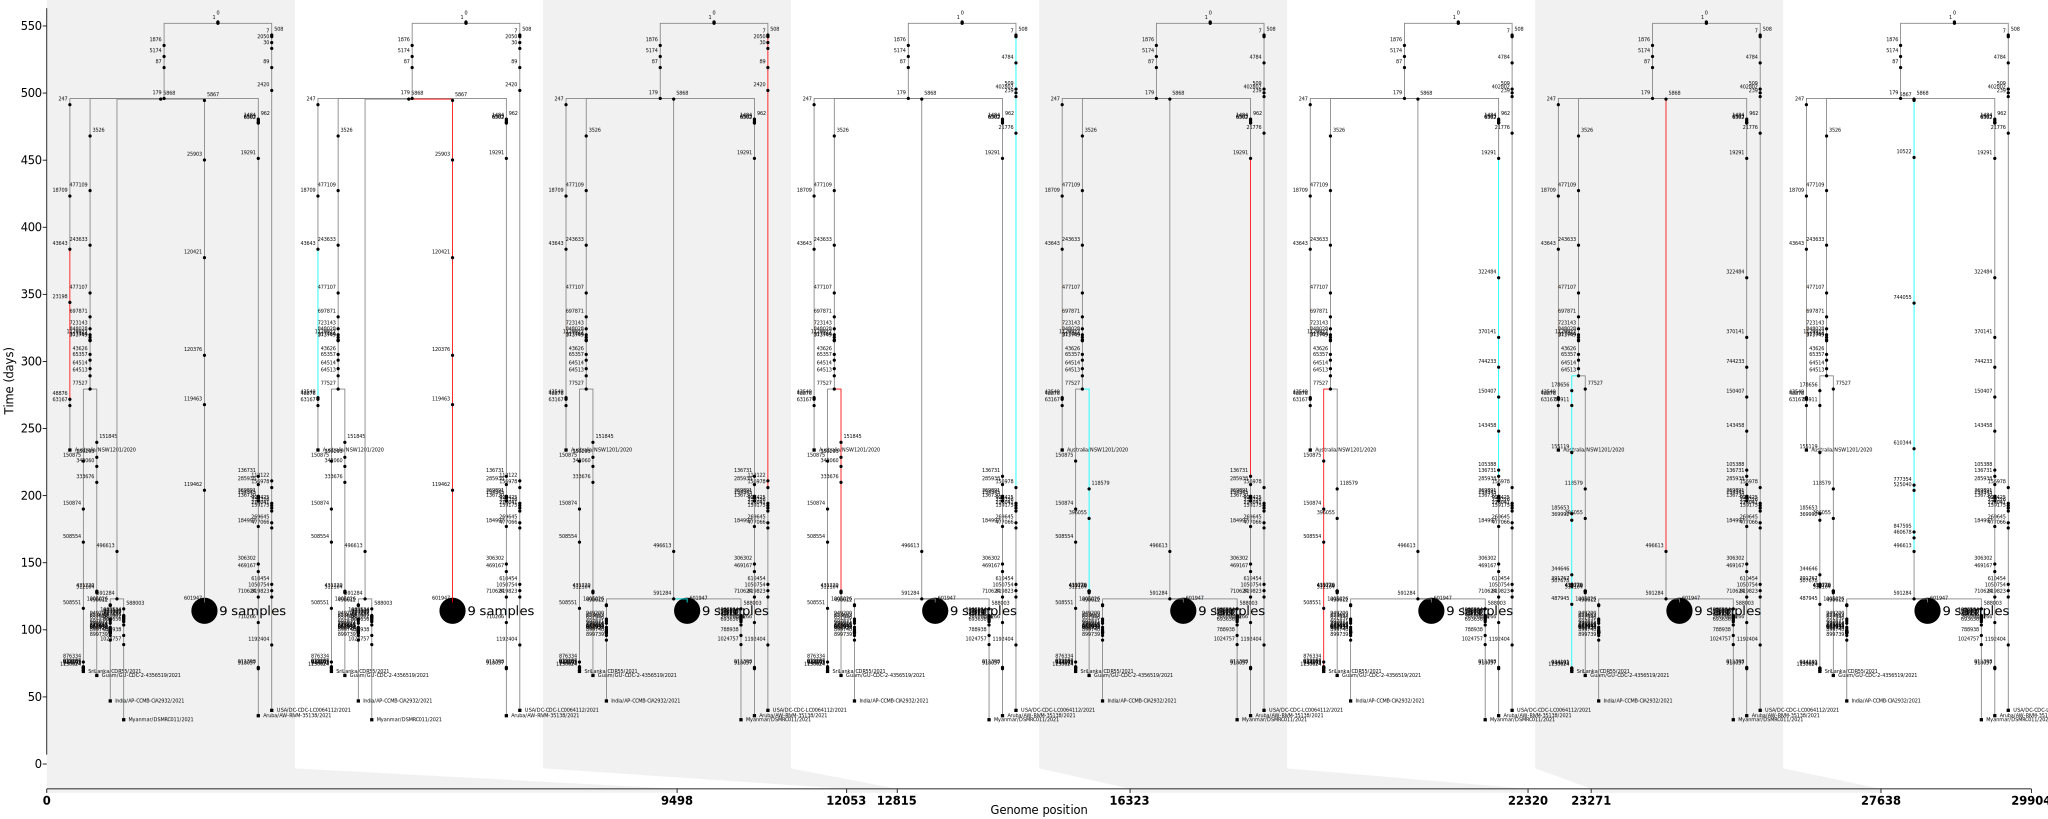

In [10]:
simp.draw_svg(
    size=(2500, 1000),
    style=style,
    y_axis=True,
    symbol_size=4,
    y_ticks = np.arange(0, 600, 50),
    omit_sites=True,
    node_labels=node_labels
)

A semi-hand-drawn version of the ARG implied by the above is at `nxstr-simplified-ARG.svg`. This makes it easier to see that the recombinations are all between close relatives (and often do not change the topology)

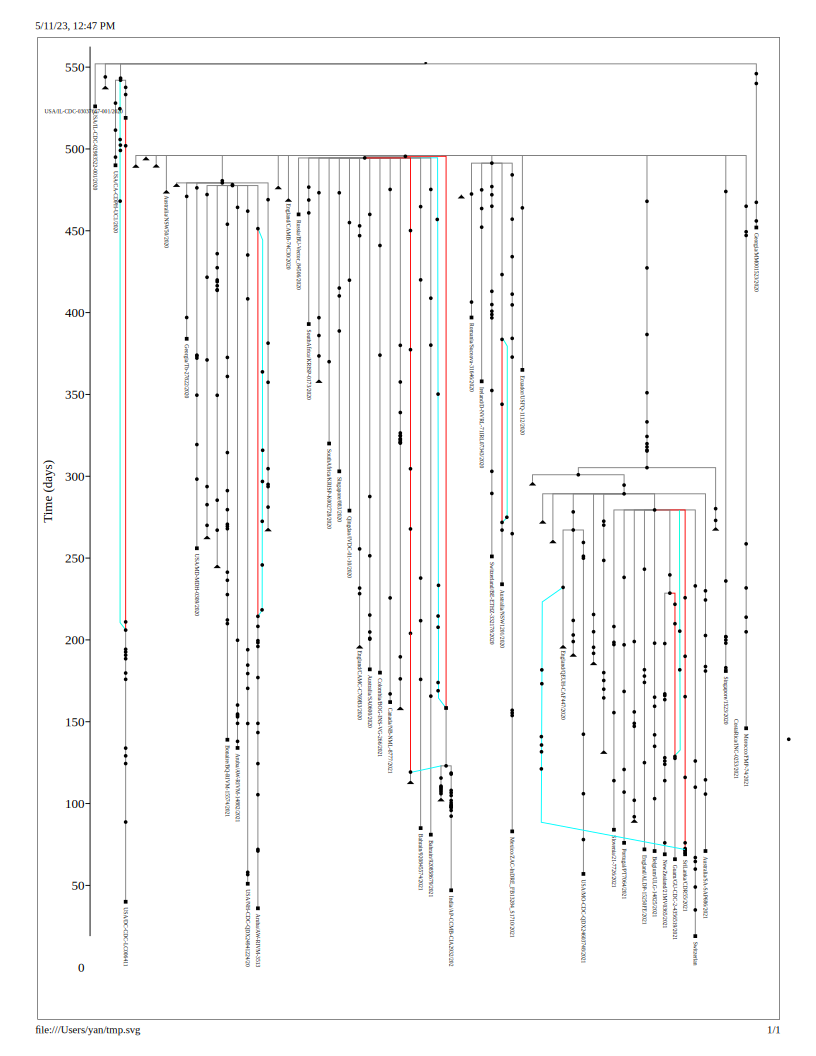

In [11]:
from IPython.display import SVG
SVG(filename="nxstr-simplified-ARG.svg")

# Save tree sequences required for tanglegram plotting

This creates "untangled" ts files in `data/` which are read by `plot.py` for creating tanglegrams. In particular, they are needed when running

```
python plot.py cophylogeny_wide
python plot.py supp_cophylogeny_long
```

In [12]:
for ts_in, fn in [(ts_wide, wide_filename), (ts_long, long_filename)]:
    ts, nx_ts = get_simplified(ts_in, nextstrain_ts, pos=pos,untangle=True)
    tszip.compress(ts, os.path.join(ts_dir, fn + "_untangled.tsz"))
    tszip.compress(nx_ts, os.path.join(ts_dir, fn + "_nxstr_untangled.tsz"))
    print("saved untangled files with prefix:", os.path.join(ts_dir, fn))

Num samples in subsetted ARG=187 vs NextStrain=180
Removed 7 samples in sc2 not in nextstrain
Removed samples that are internal in tree at pos 14952. Trees now have 180 leaf samples and 7 recmb nodes
Version   Dendroscope (version 3.8.8, built 6 Apr 2023)
Author(s) Daniel H. Huson, with some contributions from other authors
Copyright (C) 2023  Daniel H. Huson. This program comes with ABSOLUTELY NO WARRANTY.
This is free software, licensed under the terms of the GNU General Public License, Version 3.
Java version: 18.0.2.1

Trees loaded: 2
Compute tanglegram: Initialization
Neighbor-net heuristic
The minimal crossing number found is 153
Time needed for computation: 4 min.
--------------------------
Saving file: /var/folders/00/l36df9q14hv13hhw8wglncch0000gr/T/tmpug5mn44f/cophylo.nwk
written 2 trees
saved untangled files with prefix: ../data/../data/upgma-full-md-30-mm-3-2021-06-30-recinfo2-gisaid-il
Num samples in subsetted ARG=96 vs NextStrain=88
Removed 8 samples in sc2 not in nextstr